Download and install some packages (this will prompt a restart to reinitialize our env)

In [ ]:
%%capture
!pip install -q condacolab
!python3.12 -m pip install --upgrade setuptools
import condacolab
condacolab.install()
#!conda install conda-forge::lammps
!python -m ensurepip --upgrade
!conda install --yes -c conda-forge python=3.12 lammps numpy=1.26.4 mdanalysis py3dmol # dont really need these : openmm pdbfixer parmed py3dmol rdkit openff-toolkit

In [ ]:
import MDAnalysis as md
import matplotlib.pyplot as plt
from MDAnalysis.analysis.rdf import InterRDF
import MDAnalysis.analysis.msd as msd
from MDAnalysis.transformations.nojump import NoJump
import numpy as np
from scipy.stats import norm

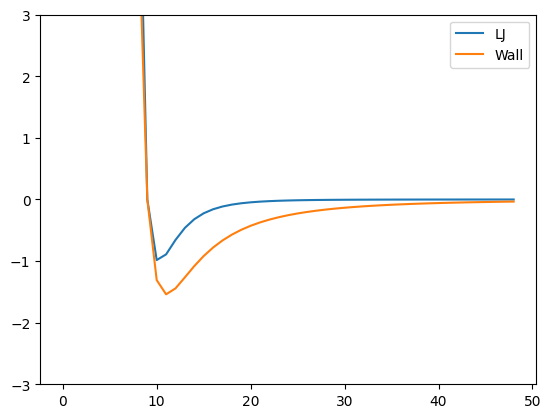

In [ ]:
lj = lambda r,eps,sig: [4*eps*((sig/i)**12-(sig/i)**6) for i in r]
r = np.arange(1,50,1)*0.1
out = lj(r,1,1)
wall = lambda r,eps,sig: [4*eps*((sig/i)**9-(sig/i)**3) for i in r]
out2 = wall(r,1,1)

fig,axs = plt.subplots()
axs.plot(out,label="LJ")
axs.plot(out2,label="Wall")
axs.set_ylim([-3,3])
axs.legend()
#out

 Test run wwith movie generation

In [ ]:
# PHASE SEPARATE
#

temp = 1.0  #         @param
box_L = 10 #@param
thermo = 10 # @param
n_particles = 200 #@param

dt = 0.005 #@param
n_steps = 100000 #@param

lmp_test_in =f"""#number of particles
variable npart  equal {n_particles}
variable temp equal {temp}
variable dt equal {dt}
variable n_steps equal {n_steps}
##
units		lj
dimension 3
atom_style	atomic
boundary        p fm p
#boundary        p p p
###
neighbor        2   bin
neigh_modify    every 1 delay 0 check yes
###
# define box region
region box block 0.0 {int(box_L/2)} 0.0 {int(box_L*2)} 0.0 {int(box_L/2)}
create_box 2 box
#bond/types 2

# define box region
region box_1 block 0.0 {int(box_L/2)} 2.5 {int(box_L)} 0.0 {int(box_L/2)}
region box_2 block 0.0 {int(box_L/2)} {int(box_L)} $({int(box_L*2)}-2.5) 0.0 {int(box_L/2)}


create_atoms 1 random ${{npart}} 324523 box_1
create_atoms 2 random ${{npart}} 252531 box_2

group wot id 1
group oil id 2

#all light particles has mass 1, the brownian particle mass 50
mass   *	1

pair_style lj/cut  2.5
pair_coeff 1 1 1.0 1.0
pair_coeff 2 2 1.0 1.0
#
pair_coeff 1 2 0.01 1.0
pair_coeff 2 1 0.01 1.0
pair_modify   shift yes

###############
fix walllow all wall/lj93 ylo EDGE 1.0 1.0 2.5 units box
fix wallhi all wall/lj93 yhi EDGE 1.0 1.0 2.5 units box
###############

#minimize energy first to avoid overlapping particles
minimize 1e-4 1e-4 10000 10000
reset_timestep 0

fix 1 all nvt temp ${{temp}} ${{temp}} $(100.0*dt)


velocity all create ${{temp}} 34234123 dist gaussian


#output time step, temperature, average kinetic and potential energy
compute msd_col all msd
thermo_style custom step temp press c_msd_col[4] ke pe
thermo		{thermo}

dump positions all custom 100 out.dump id type x y z vx vy vz

timestep ${{dt}}

#number of steps to run
run		${{n_steps}}
write_data out.data pair ij"""

with open('lmp_test_in.in','w+') as f:
  f.write(lmp_test_in)

In [ ]:
#!export OMP_NUM_THREADS=2
!mpirun --bind-to core lmp_mpi < lmp_test_in.in > out.log
!tail -25 out.log


MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 36.015     | 36.015     | 36.015     |   0.0 | 87.80
Neigh   | 1.7704     | 1.7704     | 1.7704     |   0.0 |  4.32
Comm    | 0.9772     | 0.9772     | 0.9772     |   0.0 |  2.38
Output  | 1.1975     | 1.1975     | 1.1975     |   0.0 |  2.92
Modify  | 0.8084     | 0.8084     | 0.8084     |   0.0 |  1.97
Other   |            | 0.2527     |            |       |  0.62

Nlocal:            400 ave         400 max         400 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           2744 ave        2744 max        2744 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:          58760 ave       58760 max       58760 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 58760
Ave neighs/atom = 146.9
Neighbor list builds = 1219
Dangerous builds = 0
System init for write_data ...
Generated 0 of 1 mixed pair_coeff terms from geometric mixing

/usr/local/lib/python3.12/site-packages/MDAnalysis/topology/LAMMPSParser.py:670: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/usr/local/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:749: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


Text(0.5, 0, 'y')

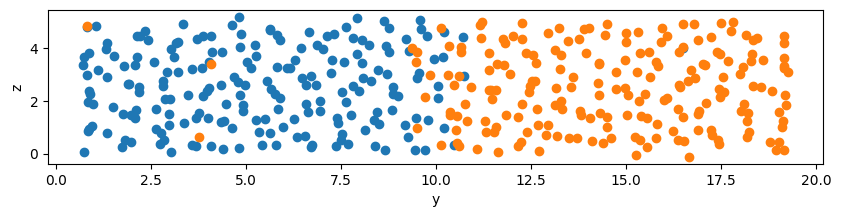

In [ ]:
trj = md.Universe("out.dump",topology_format="LAMMPSDUMP")
fig,axs = plt.subplots(figsize=(10,2))
#
trj.trajectory[-1]
oil = trj.select_atoms("type 1")
water = trj.select_atoms("type 2")
#
axs.scatter(oil.positions[:,1],oil.positions[:,2])
axs.scatter(water.positions[:,1],water.positions[:,2])
#
axs.set_ylabel("z")
axs.set_xlabel("y")
#axs.legend()

Plot prob

Text(0.5, 0, 'y')

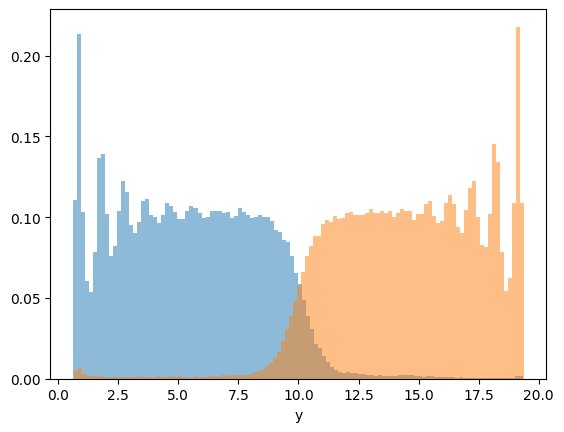

In [ ]:
trj = md.Universe("out.dump",topology_format="LAMMPSDUMP")
fig,axs = plt.subplots()
#
oil = trj.select_atoms("type 1")
water = trj.select_atoms("type 2")
#
o_oil = [] #oil.positions[:,1]
o_water = [] #water.positions[:,1]
#
for ts in trj.trajectory:
  o_oil.append(oil.positions[:,1])
  o_water.append(water.positions[:,1])
#axs.hist(o_oil,bins=[i for i in range(20)])
#axs.hist(o_water,bins=[i for i in range(20)])
bins = np.arange(0,20,0.25)
axs.hist(np.array(o_oil).flatten(),bins="auto",density=True,alpha=0.5)
axs.hist(np.array(o_water).flatten(),bins="auto",density=True,alpha=0.5)

axs.set_xlabel("y")



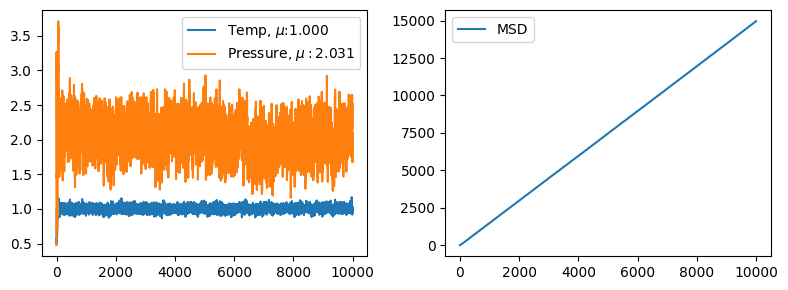

In [ ]:
# plot out
flag = False
pres = []
temp = []
msd = []
with open("out.log","r") as rr:
    for line in rr:
        t = line.split()
        try:
            if flag:
                if t[0] == "Loop":
                    break
                else:
                    pres.append(float(t[2]))
                    temp.append(float(t[1]))
                    msd.append(float(t[4]))
            if not flag:
                if (t[0] == "Step") and (t[2] != "E_pair"):
                    flag = True
        except IndexError:
            continue
#################################################################
p_mean = np.array(pres).mean()
t_mean = np.array(temp).mean()
msd = np.array(msd)
##
fig,axs = plt.subplots(1,2,figsize=(8,3))
#
axs[0].plot(temp,label=f"Temp, $\\mu$:{t_mean:0.3f}")
axs[0].plot(pres,label=f"Pressure, $\\mu:${p_mean:0.3f}")
#
axs[1].plot(msd.cumsum(),label="MSD")
#
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

In [ ]:
trj = md.Universe("out.dump",topology_format="LAMMPSDUMP")
oil = trj.select_atoms('type 1')
water = trj.select_atoms('type 2')
#
oil_rdf = InterRDF(oil,oil,range=(0.5,3))
water_rdf = InterRDF(water,water,range=(0.5,3))
wat_o =  InterRDF(water,oil,range=(0.5,3))
#
wat_o.run()
oil_rdf.run()
water_rdf.run()

/usr/local/lib/python3.12/site-packages/MDAnalysis/analysis/rdf.py:430: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.12/site-packages/MDAnalysis/analysis/rdf.py:440: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


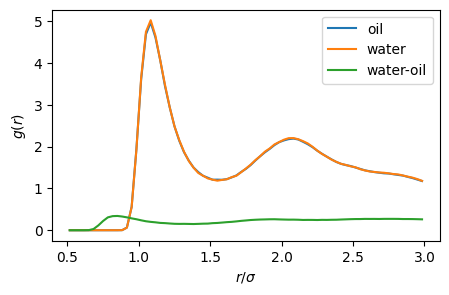

In [ ]:
fig,axs = plt.subplots(figsize=(5,3))
#axs.scatter(rdf.bins, rdf.rdf,s=20,alpha=0.5,edgecolors='black',label='')
axs.plot(oil_rdf.bins,oil_rdf.rdf,label="oil")
axs.plot(water_rdf.bins,water_rdf.rdf,label="water")
axs.plot(wat_o.bins,wat_o.rdf,label="water-oil")
#axs.set_ylim(0,None)
axs.set_xlabel("$r/\\sigma$")
axs.set_ylabel("$g(r)$")
axs.legend()

Run :)

In [ ]:
%%capture
trj = md.Universe("out.dump",topology_format="LAMMPSDUMP")
with md.Writer("out.pdb",trj.atoms.n_atoms) as W:
  for ts in trj.trajectory:
    W.write(trj.atoms)

Lets move

## COLVARS ON THE INTERFACE

# standard Metadynamics

In [ ]:
variables=f"""colvarsTrajFrequency 10
colvar {{
  name dist
  lowerBoundary 0.0
  upperBoundary 15.0
  width 0.5
  distance {{
  group1 {{atomNumbers { 2*n_particles+1 }}}
  group2 {{atomNumbers { 2*n_particles+2 }}}
  }}
}}

"""
colvars =f"""{variables}
metadynamics  {{
  name meta_r
  colvars dist
  hillWeight 0.001
  hillWidth 1.0
  newHillFrequency 500
  outputFreq  10
  useGrids on
  writeFreeEnergyFile on
  #writeTIPMF on
  outputEnergy on

}}

harmonicWalls {{
  name wall_r
  colvars dist
  upperWalls 13.0
  upperWallConstant 2.0
}}
"""
with open("in.colvars","w+") as w:
  w.write(colvars)

In [ ]:
#@title run
# PHASE SEPARATE
#
dens = 0.75
temp = 1.0
box_L = 10 # 1/2 box length
thermo = 10 # step to dump thermo
n_particles = 200 #np.floor(dens*2*(box_L))

dt = 0.005
n_steps = 100000

lmp_test_in =f"""#number of particles
variable npart  equal {n_particles}
variable temp equal {temp}
variable dt equal {dt}
variable n_steps equal {n_steps}
##
units		lj
dimension 3
atom_style	atomic
boundary        p fm p
#boundary        p p p
###
neighbor        2   bin
neigh_modify    every 1 delay 0 check yes
atom_modify map yes
###
# define box region
region box block 0.0 {int(box_L/2)} 0.0 {int(box_L*2)} 0.0 {int(box_L/2)}
create_box 4 box
#bond/types 2

# define box region
region box_1 block 0.0 {int(box_L/2)} 2.5 {int(box_L)} 0.0 {int(box_L/2)}
region box_2 block 0.0 {int(box_L/2)} {int(box_L)} $({int(box_L*2)}-2.5) 0.0 {int(box_L/2)}

### CREATE ATOMS
create_atoms 1 random ${{npart}} 324523 box_1
create_atoms 2 random ${{npart}} 252531 box_2
# ADD TWO 'NANOS' ON THE SURFACE
create_atoms 3 single 2.5 10.0 1.0
create_atoms 4 single 2.5 10.0 3.0
####

group wot id 1
group oil id 2

#all light particles has mass 1, the brownian particle mass 50
mass   *	1

pair_style lj/cut  2.5
# FOR OIL AND WOTER
pair_coeff 1 1 1.0 1.0
pair_coeff 2 2 1.0 1.0
#
pair_coeff 1 2 0.01 1.0
pair_coeff 2 1 0.01 1.0

# FOR NANO
pair_coeff 3 4 1.0 1.0
pair_coeff 3 3 1.0 1.0

pair_coeff 4 3 1.0 1.0
pair_coeff 4 4 1.0 1.0

# part 1 and nano
pair_coeff 1 3 0.5 1.0
pair_coeff 1 3 0.5 1.0

pair_coeff 1 4 0.5 1.0
pair_coeff 1 4 0.5 1.0

# part 2 and nano
pair_coeff 2 3 0.5 1.0
pair_coeff 2 3 0.5 1.0

pair_coeff 2 4 0.5 1.0
pair_coeff 2 4 0.5 1.0

# SHIFT LJ AT CUTOFF
pair_modify   shift yes

###############
fix walllow all wall/lj93 ylo EDGE 1.0 1.0 2.5 units box
fix wallhi all wall/lj93 yhi EDGE 1.0 1.0 2.5 units box
###############
#
#minimize energy first to avoid overlapping particles
minimize 1e-4 1e-4 10000 10000
reset_timestep 0

fix NVT all nvt temp ${{temp}} ${{temp}} $(100.0*dt)


velocity all create ${{temp}} 34234123 dist gaussian


#output time step, temperature, average kinetic and potential energy
compute msd_col all msd
thermo_style custom step temp press c_msd_col[4] ke pe
thermo		{thermo}

dump positions all custom 100 eq_colvar.dump id type x y z vx vy vz
dump_modify positions sort id

timestep ${{dt}}

#number of steps to run
run		${{n_steps}}
print "equilibration done"

fix Colvars all colvars in.colvars output out.colvars tstat NVT
undump positions
dump positions all custom 100 colvar_test_out.dump id type x y z vx vy vz
dump_modify positions sort id
run		${{n_steps}}

"""

with open('colvar_test_in.in','w+') as f:
  f.write(lmp_test_in)

In [ ]:
!mpirun --bind-to core lmp_mpi < colvar_test_in.in > colvar_test.log
!tail -25 colvar_test.log

Output  | 1.7592     | 1.7592     | 1.7592     |   0.0 |  2.72
Modify  | 6.3035     | 6.3035     | 6.3035     |   0.0 |  9.75
Other   |            | 0.4092     |            |       |  0.63

Nlocal:            402 ave         402 max         402 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           2751 ave        2751 max        2751 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:          58812 ave       58812 max       58812 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 58812
Ave neighs/atom = 146.29851
Neighbor list builds = 1215
Dangerous builds = 0

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- Colvars module (Fiorin2013, plus other works listed for specific features)
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Total wall time: 0:02:03


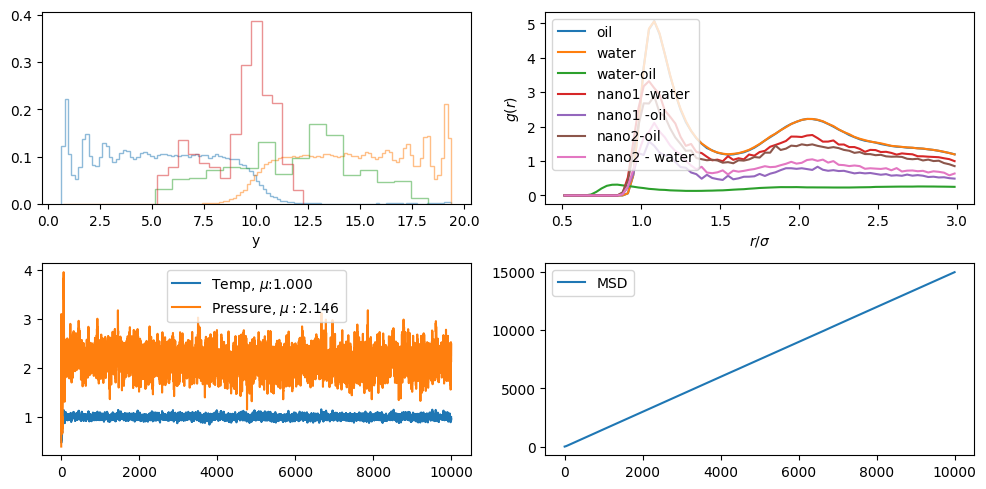

In [ ]:
#@title plot thermo
trj = md.Universe("eq_colvar.dump",topology_format="LAMMPSDUMP")
fig,axs = plt.subplots(2,2,figsize=(10,5))
#
oil = trj.select_atoms("type 1")
water = trj.select_atoms("type 2")
#
nano1 = trj.select_atoms("type 3")
nano2 = trj.select_atoms("type 4")
#
o_n1 = []
o_n2 = []
o_oil = [] #oil.positions[:,1]
o_water = [] #water.positions[:,1]
#
#
for ts in trj.trajectory:
  o_oil.append(oil.positions[:,1])
  o_water.append(water.positions[:,1])
  o_n1.append(nano1.positions[:,1])
  o_n2.append(nano2.positions[:,1])

#axs.hist(o_oil,bins=[i for i in range(20)])
#axs.hist(o_water,bins=[i for i in range(20)])
bins = np.arange(0,20,0.25)
axs[0][0].hist(np.array(o_oil).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')
axs[0][0].hist(np.array(o_water).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')
# nano[0]s
axs[0][0].hist(np.array(o_n1).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')
axs[0][0].hist(np.array(o_n2).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')

axs[0][0].set_xlabel("y")
############################ RDF
#
oil_rdf = InterRDF(oil,oil,range=(0.5,3))
water_rdf = InterRDF(water,water,range=(0.5,3))
wat_o =  InterRDF(water,oil,range=(0.5,3))
#
nano2_oil = InterRDF(nano2,oil,range=(0.5,3))
nano1_oil = InterRDF(nano1,oil,range=(0.5,3))
nano2_water = InterRDF(nano2,water,range=(0.5,3))
nano1_water = InterRDF(nano1,water,range=(0.5,3))
#
nano2_oil.run()
nano1_oil.run()
nano2_water.run()
nano1_water.run()

wat_o.run()
oil_rdf.run()
water_rdf.run()

#axs.scatter(rdf.bins, rdf.rdf,s=20,alpha=0.5,edgecolors='black',label='')
axs[0][1].plot(oil_rdf.bins,oil_rdf.rdf,label="oil")
axs[0][1].plot(water_rdf.bins,water_rdf.rdf,label="water")
axs[0][1].plot(wat_o.bins,wat_o.rdf,label="water-oil")
axs[0][1].plot(nano1_water.bins,nano1_water.rdf,label="nano1 -water")
axs[0][1].plot(nano1_oil.bins,nano1_oil.rdf,label="nano1 -oil")
axs[0][1].plot(nano2_oil.bins,nano2_oil.rdf,label="nano2-oil")
axs[0][1].plot(nano2_water.bins,nano2_water.rdf,label="nano2 - water")
#ax[0][1]s.set_ylim(0,None)
axs[0][1].set_xlabel("$r/\\sigma$")
axs[0][1].set_ylabel("$g(r)$")
axs[0][1].legend()
############# THERMO
# plot out
flag = False
pres = []
temp = []
msd = []
with open("colvar_test.log","r") as rr:
    for line in rr:
        t = line.split()
        try:
            if flag:
                if t[0] == "Loop":
                    break
                else:
                    pres.append(float(t[2]))
                    temp.append(float(t[1]))
                    msd.append(float(t[4]))
            if not flag:
                if (t[0] == "Step") and (t[2] != "E_pair"):
                    flag = True
        except IndexError:
            continue
#################################################################
p_mean = np.array(pres).mean()
t_mean = np.array(temp).mean()
msd = np.array(msd)
#
axs[1][0].plot(temp,label=f"Temp, $\\mu$:{t_mean:0.3f}")
axs[1][0].plot(pres,label=f"Pressure, $\\mu:${p_mean:0.3f}")
#[1]
axs[1][1].plot(msd.cumsum(),label="MSD")
#[1]
axs[1][0].legend()
axs[1][1].legend()
fig.tight_layout()

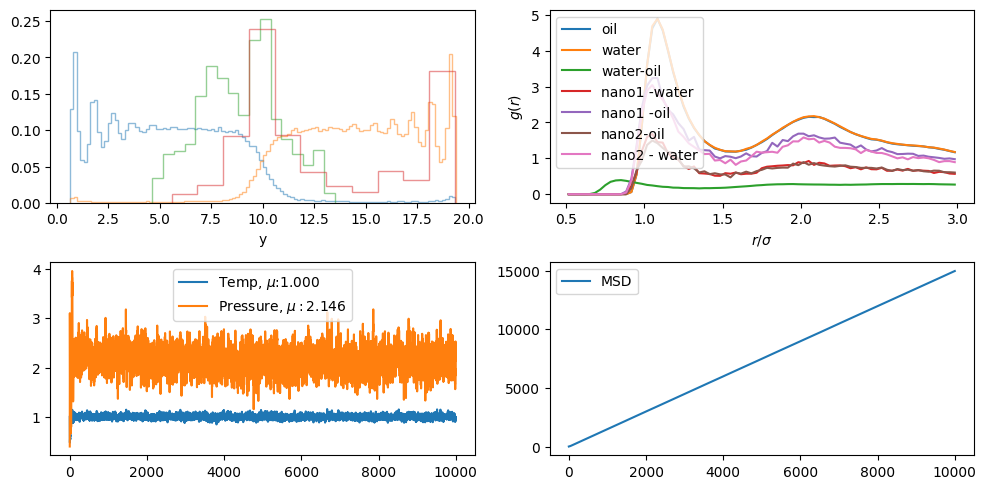

In [ ]:
#@title plot thermo w/META
trj = md.Universe("colvar_test_out.dump",topology_format="LAMMPSDUMP")
fig,axs = plt.subplots(2,2,figsize=(10,5))
#
oil = trj.select_atoms("type 1")
water = trj.select_atoms("type 2")
#
nano1 = trj.select_atoms("type 3")
nano2 = trj.select_atoms("type 4")
#
o_n1 = []
o_n2 = []
o_oil = [] #oil.positions[:,1]
o_water = [] #water.positions[:,1]
#
#
for ts in trj.trajectory:
  o_oil.append(oil.positions[:,1])
  o_water.append(water.positions[:,1])
  o_n1.append(nano1.positions[:,1])
  o_n2.append(nano2.positions[:,1])

#axs.hist(o_oil,bins=[i for i in range(20)])
#axs.hist(o_water,bins=[i for i in range(20)])
bins = np.arange(0,20,0.25)
axs[0][0].hist(np.array(o_oil).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')
axs[0][0].hist(np.array(o_water).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')
# nano[0]s
axs[0][0].hist(np.array(o_n1).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')
axs[0][0].hist(np.array(o_n2).flatten(),bins="auto",density=True,alpha=0.5,histtype='step')

axs[0][0].set_xlabel("y")
############################ RDF
#
oil_rdf = InterRDF(oil,oil,range=(0.5,3))
water_rdf = InterRDF(water,water,range=(0.5,3))
wat_o =  InterRDF(water,oil,range=(0.5,3))
#
nano2_oil = InterRDF(nano2,oil,range=(0.5,3))
nano1_oil = InterRDF(nano1,oil,range=(0.5,3))
nano2_water = InterRDF(nano2,water,range=(0.5,3))
nano1_water = InterRDF(nano1,water,range=(0.5,3))
#
nano2_oil.run()
nano1_oil.run()
nano2_water.run()
nano1_water.run()

wat_o.run()
oil_rdf.run()
water_rdf.run()

#axs.scatter(rdf.bins, rdf.rdf,s=20,alpha=0.5,edgecolors='black',label='')
axs[0][1].plot(oil_rdf.bins,oil_rdf.rdf,label="oil")
axs[0][1].plot(water_rdf.bins,water_rdf.rdf,label="water")
axs[0][1].plot(wat_o.bins,wat_o.rdf,label="water-oil")
axs[0][1].plot(nano1_water.bins,nano1_water.rdf,label="nano1 -water")
axs[0][1].plot(nano1_oil.bins,nano1_oil.rdf,label="nano1 -oil")
axs[0][1].plot(nano2_oil.bins,nano2_oil.rdf,label="nano2-oil")
axs[0][1].plot(nano2_water.bins,nano2_water.rdf,label="nano2 - water")
#ax[0][1]s.set_ylim(0,None)
axs[0][1].set_xlabel("$r/\\sigma$")
axs[0][1].set_ylabel("$g(r)$")
axs[0][1].legend()
############# THERMO
# plot out
flag = False
pres = []
temp = []
msd = []
with open("colvar_test.log","r") as rr:
    for line in rr:
        t = line.split()
        try:
            if flag:
                if t[0] == "Loop":
                    break
                else:
                    pres.append(float(t[2]))
                    temp.append(float(t[1]))
                    msd.append(float(t[4]))
            if not flag:
                if (t[0] == "Step") and (t[2] != "E_pair"):
                    flag = True
        except IndexError:
            continue
#################################################################
p_mean = np.array(pres).mean()
t_mean = np.array(temp).mean()
msd = np.array(msd)
#
axs[1][0].plot(temp,label=f"Temp, $\\mu$:{t_mean:0.3f}")
axs[1][0].plot(pres,label=f"Pressure, $\\mu:${p_mean:0.3f}")
#[1]
axs[1][1].plot(msd.cumsum(),label="MSD")
#[1]
axs[1][0].legend()
axs[1][1].legend()
fig.tight_layout()

In [ ]:
!head out.colvars.pmf

# 1
#  0.00000000000000e+00  5.00000000000000e-01         30  0

  2.50000000000000e-01   2.82917564393385e-02
  7.50000000000000e-01   2.45394312121962e-02
  1.25000000000000e+00   1.04678628441678e-02
  1.75000000000000e+00   1.17799288678250e-02
  2.25000000000000e+00  -0.00000000000000e+00
  2.75000000000000e+00   4.22220050882955e-03
  3.25000000000000e+00   8.38983142510885e-03


Text(0.5, 0, '$\\xi$ / r')

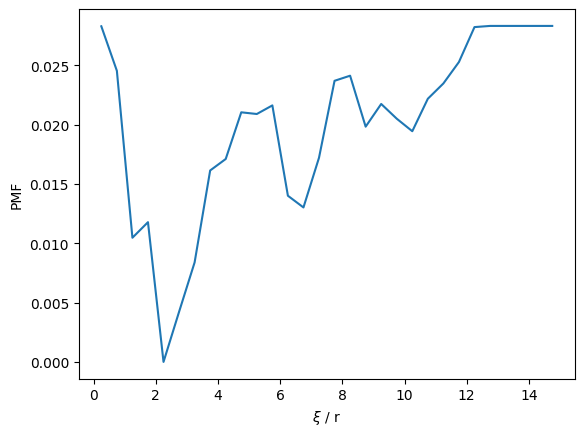

In [ ]:
pmf = []
step = []

with open("out.colvars.pmf","r") as r:
  for line in r:
    if line[0] != "#":
      try:
        t = line.split()
        pmf.append(float(t[1]))
        step.append(float(t[0]))
      except Exception as exc:
        continue
fig,axs = plt.subplots()
axs.plot(step,pmf)
axs.set_ylabel("PMF")
axs.set_xlabel("$\\xi$ / r")

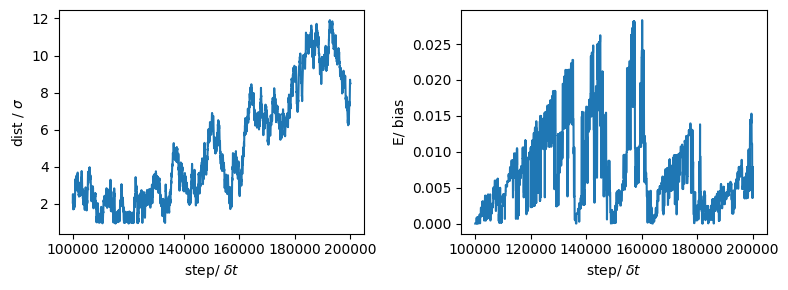

In [ ]:
# plot metaD
step = []
val = []
energ = []
with open("out.colvars.colvars.traj") as t:
  for line in t:
    tmp = line.split()
    try:
      step.append(float(tmp[0]))
      val.append(float(tmp[1]))
      energ.append(float(tmp[2]))
    except Exception as exc:
      continue
fig,axs =plt.subplots(1,2,figsize=(8,3))
axs[0].plot(step,val)
axs[0].set_ylabel("dist / $\\sigma$")
axs[0].set_xlabel("step/ $\\delta t$")
##
axs[1].plot(step,energ)
axs[1].set_ylabel("E/ bias")
axs[1].set_xlabel("step/ $\\delta t$")
fig.tight_layout()

# OPES-Metadynamics

In [ ]:
variables=f"""colvarsTrajFrequency 10
colvar {{
  name distr
  lowerBoundary 0.0
  upperBoundary 15
  width 0.5
  distance {{
  group1 {{atomNumbers { 2*n_particles+1 }}}
  group2 {{atomNumbers { 2*n_particles+2 }}}
  }}
}}

"""
variables=f"""colvarsTrajFrequency 10
colvar {{
  name distr
  lowerBoundary 0.0
  upperBoundary 10
  width 0.5
  distance {{
  group1 {{atomNumbers { 2*n_particles+1 }}}
  group2 {{atomNumbers { 2*n_particles+2 }}}
  }}
}}

colvar {{
  name dist_i
  width 0.5
  upperBoundary 10
  distanceZ  {{
  main {{atomNumbers { 2*n_particles+2 } }}
  ref {{dummyAtom  (2.5, 10.0, 2.5)}}
  axis (0.0, 1.0, 0.0)
  }}
}}

colvar {{
  name dist_j
  width 0.5
  upperBoundary 10
  distanceZ  {{
  main {{atomNumbers { 2*n_particles+1 } }}
  ref {{dummyAtom  (2.5, 10.0, 2.5)}}
  axis (0.0, 1.0, 0.0)
  }}
}}

"""
####
"""
colvar {{
  name dist_i
  width 10.0
  distancePairs  {{
  group1 {{dummyAtom  (2.5, 10.0, 2.5)}}
  group2 {{atomNumbers { 2*n_particles+1 } { 2*n_particles+2 } }}
  }}
}}

"""
#####
colvars =f"""{variables}
opes_metad {{
  name oops_meta
  colvars distr
  newHillFrequency 100
  barrier 10
  biasfactor 10
  adaptiveSigma on
  neighborList on
  printTrajectoryFrequency 50
  pmf on
  pmfColvars distr
  pmfHistoryFrequency 50
  outputEnergy on
}}
"""
#########
colvars =f"""{variables}
metadynamics  {{
  name meta_r
  colvars distr dist_i dist_j
  hillWeight 0.001
  hillWidth 1.0
  newHillFrequency 100
  outputFreq  10
  useGrids on
  writeFreeEnergyFile on
  #writeTIPMF on
  outputEnergy on
}}

harmonicWalls {{
  name walls
  colvars    distr dist_i dist_j
  upperWalls 8.0  8.0   8.0
  upperWallConstant 2.0
}}

"""
with open("opes_in.colvars","w+") as w:
  w.write(colvars)

In [ ]:
#@title run
# PHASE SEPARATE
#
dens = 0.75
temp = 1.0
box_L = 10 # 1/2 box length
thermo = 1000 # step to dump thermo
n_particles = 200 #np.floor(dens*2*(box_L))

dt = 0.005
n_steps = 100000

lmp_test_in =f"""#number of particles
variable npart  equal {n_particles}
variable temp equal {temp}
variable dt equal {dt}
variable n_steps equal {n_steps}
##
units		lj
dimension 3
atom_style	atomic
boundary        p fm p
#boundary        p p p
###
neighbor        2   bin
neigh_modify    every 1 delay 0 check yes
atom_modify map yes
###
# define box region
region box block 0.0 {int(box_L/2)} 0.0 {int(box_L*2)} 0.0 {int(box_L/2)}
create_box 4 box
#bond/types 2

# define box region
region box_1 block 0.0 {int(box_L/2)} 2.5 {int(box_L)} 0.0 {int(box_L/2)}
region box_2 block 0.0 {int(box_L/2)} {int(box_L)} $({int(box_L*2)}-2.5) 0.0 {int(box_L/2)}

### CREATE ATOMS
create_atoms 1 random ${{npart}} 324523 box_1
create_atoms 2 random ${{npart}} 252531 box_2
# ADD TWO 'NANOS' ON THE SURFACE
create_atoms 3 single 2.5 10.0 1.0
create_atoms 4 single 2.5 10.0 3.0
####

group wot id 1
group oil id 2

#all light particles has mass 1, the brownian particle mass 50
mass   *	1

pair_style lj/cut  2.5
# FOR OIL AND WOTER
pair_coeff 1 1 1.0 1.0
pair_coeff 2 2 1.0 1.0
#
pair_coeff 1 2 0.01 1.0
pair_coeff 2 1 0.01 1.0

# FOR NANO
pair_coeff 3 4 1.0 1.0
pair_coeff 3 3 1.0 1.0

pair_coeff 4 3 1.0 1.0
pair_coeff 4 4 1.0 1.0

# part 1 and nano
pair_coeff 1 3 0.5 1.0
pair_coeff 1 3 0.5 1.0

pair_coeff 1 4 0.5 1.0
pair_coeff 1 4 0.5 1.0

# part 2 and nano
pair_coeff 2 3 0.5 1.0
pair_coeff 2 3 0.5 1.0

pair_coeff 2 4 0.5 1.0
pair_coeff 2 4 0.5 1.0

# SHIFT LJ AT CUTOFF
pair_modify   shift yes

###############
fix walllow all wall/lj93 ylo EDGE 1.0 1.0 2.5 units box
fix wallhi all wall/lj93 yhi EDGE 1.0 1.0 2.5 units box
###############
#
#minimize energy first to avoid overlapping particles
minimize 1e-4 1e-4 10000 10000
reset_timestep 0

fix NVT all nvt temp ${{temp}} ${{temp}} $(100.0*dt)


velocity all create ${{temp}} 34234123 dist gaussian


#output time step, temperature, average kinetic and potential energy
compute msd_col all msd
thermo_style custom step temp press c_msd_col[4] ke pe
thermo		{thermo}

dump positions all custom 100 eq_colvar.dump id type x y z vx vy vz
dump_modify positions sort id

timestep ${{dt}}

#number of steps to run
run		${{n_steps}}
print "equilibration done"

fix Colvars all colvars opes_in.colvars output out_opes.colvars tstat NVT
undump positions
dump positions all custom 100 opes.dump id type x y z vx vy vz
dump_modify positions sort id
run		${{n_steps}}

"""

with open('opes.in','w+') as f:
  f.write(lmp_test_in)

In [ ]:
!mpirun --bind-to core lmp_mpi < opes.in > opes_test.log
!tail -25 opes_test.log

Output  | 1.8761     | 1.8761     | 1.8761     |   0.0 |  0.56
Modify  | 275.83     | 275.83     | 275.83     |   0.0 | 82.17
Other   |            | 0.5582     |            |       |  0.17

Nlocal:            402 ave         402 max         402 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Nghost:           2729 ave        2729 max        2729 min
Histogram: 1 0 0 0 0 0 0 0 0 0
Neighs:          58914 ave       58914 max       58914 min
Histogram: 1 0 0 0 0 0 0 0 0 0

Total # of neighbors = 58914
Ave neighs/atom = 146.55224
Neighbor list builds = 1258
Dangerous builds = 0

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- Colvars module (Fiorin2013, plus other works listed for specific features)
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Total wall time: 0:06:37


In [ ]:
!head -2 out_opes.colvars.pmf

# 3
#  0.00000000000000e+00  5.00000000000000e-01         20  0
#  0.00000000000000e+00  5.00000000000000e-01         20  0
#  0.00000000000000e+00  5.00000000000000e-01         20  0

  2.50000000000000e-01  2.50000000000000e-01  2.50000000000000e-01   1.37178474779528e-02
  2.50000000000000e-01  2.50000000000000e-01  7.50000000000000e-01   1.37179423804829e-02
  2.50000000000000e-01  2.50000000000000e-01  1.25000000000000e+00   1.37179423804829e-02
  2.50000000000000e-01  2.50000000000000e-01  1.75000000000000e+00   1.37179423804829e-02
  2.50000000000000e-01  2.50000000000000e-01  2.25000000000000e+00   1.37179423804829e-02
  2.50000000000000e-01  2.50000000000000e-01  2.75000000000000e+00   1.37179423804829e-02
  2.50000000000000e-01  2.50000000000000e-01  3.25000000000000e+00   1.37179423804829e-02
  2.50000000000000e-01  2.50000000000000e-01  3.75000000000000e+00   1.37179423804829e-02
  2.50000000000000e-01  2.50000000000000e-01  4.25000000000000e+00   1.37179423804829e-02
  2.5

In [ ]:
len(pmf)/20

400.0

Text(0.5, 0, '$\\xi$ / r')

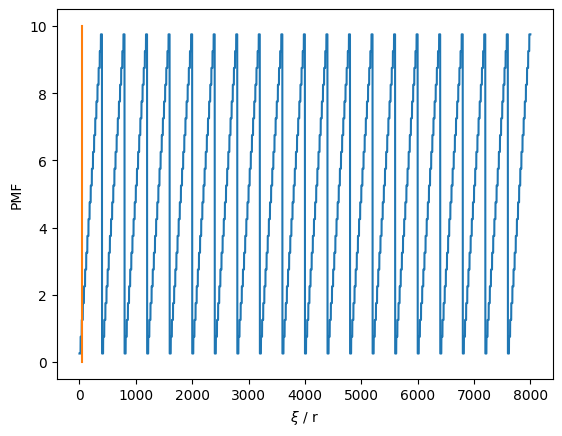

In [ ]:
pmf = []
step = []

with open("out_opes.colvars.pmf","r") as r:
  for line in r:
    if line[0] != "#":
      try:
        t = line.split()
        pmf.append(float(t[-1]))
        step.append(float(t[1]))
      except Exception as exc:
        continue
fig,axs = plt.subplots()
#axs.plot(step,pmf)
#axs.plot(pmf)
axs.plot(step)
axs.plot([40,40],[0,10])
axs.set_ylabel("PMF")
axs.set_xlabel("$\\xi$ / r")

Text(0.5, 0, '$\\xi$ / r')

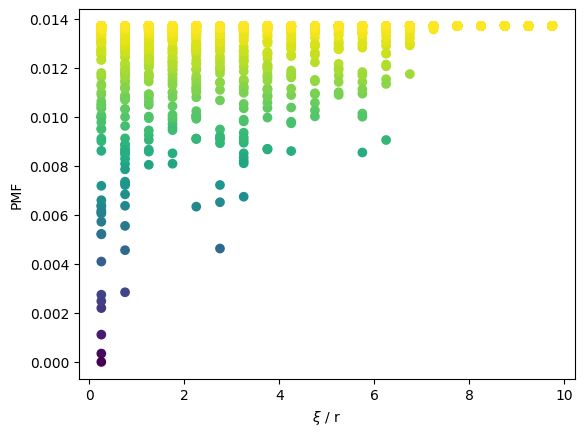

In [ ]:
pmf = []
step1 = []
step2 = []

with open("out_opes.colvars.pmf","r") as r:
  for line in r:
    if line[0] != "#":
      try:
        t = line.split()
        pmf.append(float(t[-1]))
        step1.append(float(t[1]))
        step2.append(float(t[2]))
      except Exception as exc:
        continue
fig,axs = plt.subplots()
p = axs.scatter(step1,pmf,c=pmf)
##
fig.colorbar(p,ax=ax, label="idk")
axs.set_ylabel("PMF")
axs.set_xlabel("$\\xi$ / r")

ValueError: not enough values to unpack (expected 2, got 1)

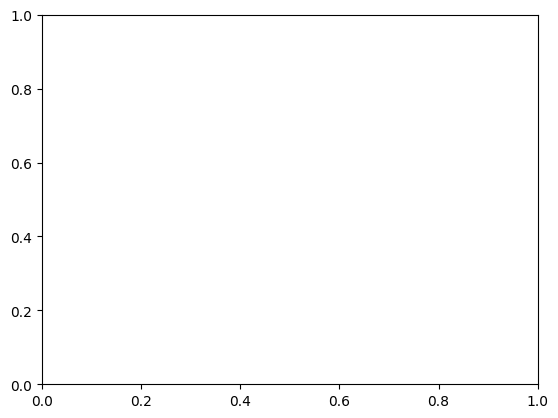

In [ ]:
pmf = []
xi1 = []
xi2 = []
xi3 = []
##
with open("out_opes.colvars.pmf","r") as r:
  for line in r:
    if line[0] != "#":
      try:
        t = line.split()
        pmf.append(float(t[-1]))
        #step.append(float(t[0]))
        xi1.append(float(t[0]))
        xi2.append(float(t[1]))
        xi3.append(float(t[2]))
      except Exception as exc:
        continue
fig,axs = plt.subplots()
#axs.plot(step,pmf)
v = np.array(pmf)[-100:]
p = ax.pcolormesh(xi1[-20:],xi2[-20:],v,shading='gouraud')
##
fig.colorbar(p,ax=ax, label="$g(\\vec{r})/\\mathring{{A}}$")
axs.set_ylabel("PMF")
axs.set_xlabel("$\\xi$ / r")

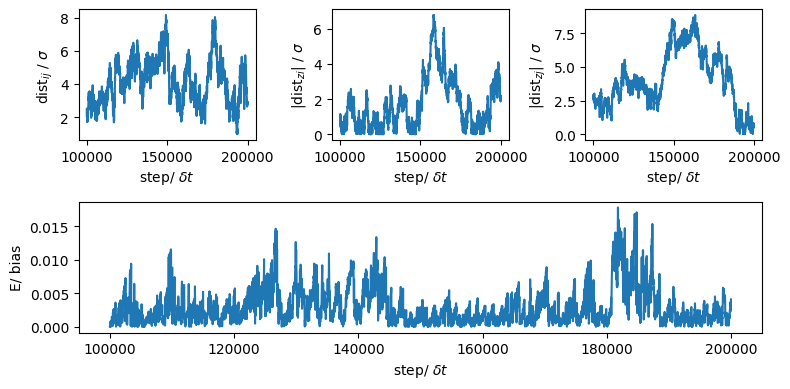

In [ ]:
# plot metaD
step = []
distr = []
disti = []
distj = []
#
energ = []
with open("out_opes.colvars.colvars.traj") as t:
  for line in t:
    tmp = line.split()
    if tmp[0] != "#":
      try:
        step.append(float(tmp[0]))
        distr.append(float(tmp[1]))
        disti.append(float(tmp[2]))
        distj.append(float(tmp[3]))
        #
        energ.append(float(tmp[-1]))
      except Exception as exc:
        continue
fig,axs = plt.subplots(2,3,figsize=(8,4))
axs[0][0].plot(step,distr)
axs[0][0].set_ylabel("dist$_{ij}$ / $\\sigma$")
axs[0][0].set_xlabel("step/ $\\delta t$")
##[]
axs[0][1].plot(step,np.abs(disti))
axs[0][1].set_ylabel("|dist$_{zi}$| / $\\sigma$")
axs[0][1].set_xlabel("step/ $\\delta t$")
##[]
axs[0][2].plot(step,np.abs(distj))
axs[0][2].set_ylabel("|dist$_{zj}$| / $\\sigma$")
axs[0][2].set_xlabel("step/ $\\delta t$")
##
gs = axs[1,1].get_gridspec()
# remove the underlying Axes
for ax in axs[1,:]:
    ax.remove()
axbig = fig.add_subplot(gs[1,:])
axbig.plot(step,energ)
axbig.set_ylabel("E/ bias")
axbig.set_xlabel("step/ $\\delta t$")
fig.tight_layout()

# between one particle and the interface

## save

5000000 with 50 particles and 10 box = 1min

In [ ]:
!lmp < lmp_test_in.in > mps.log

In [ ]:
trj.trajectory[-1]

< Timestep 77 with unit cell dimensions [ 5. 20.  5. 90. 90. 90.] >

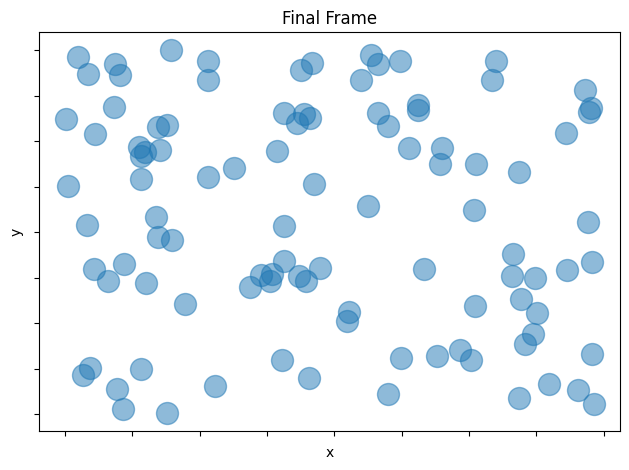

In [ ]:
fig,axs = plt.subplots()

x,y,_ = trj.trajectory[-1].positions.T

axs.scatter(x,y,s=250,alpha=0.5)
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_xticklabels([])
axs.set_yticklabels([])
axs.set_title("Final Frame")
fig.tight_layout()

In [ ]:
x,y,_ = [],[],[]
# get rid of PBC
transformation = NoJump()
trj.trajectory.add_transformations(transformation)
for ts in trj.trajectory:
  tmp = trj.atoms.velocities.T
  x.append(tmp[0])
  #y.append(tmp[1])

MSD = msd.EinsteinMSD(trj, select='all', msd_type='xyz', fft=True)
MSD.run()
msd_ =  MSD.results.timeseries
nframes = MSD.n_frames
lagtimes = np.arange(nframes)*time_step
exact = lagtimes*6
##

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [ ]:
#take average of traj
xx = np.array(x)
mean_vx_per_ts = np.empty(xx.shape[0])
for ind,vx in enumerate(xx):
 mean_vx_per_ts[ind] = np.abs(vx.mean())


In [ ]:
#take average position of traj
x = y =_ =[]
for ts in trj.trajectory:
  tmp = trj.atoms.positions.T
  x.append(tmp[0])
  y.append(tmp[1])


In [ ]:
xp = np.array(x)
yp = np.array(y)
mean_x_per_ts = np.empty(xp.shape[0])
mean_y_per_ts = np.empty(xp.shape[0])
for ind,(x_p,y_p) in enumerate(zip(xp,yp)):
 mean_x_per_ts[ind] = x_p.mean()
 mean_y_per_ts[ind] = y_p.mean()
pdf_xp = norm.pdf(mean_x_per_ts,loc=mean_x_per_ts.mean(),scale=mean_x_per_ts.std())
pdf_yp = norm.pdf(mean_y_per_ts,loc=mean_y_per_ts.mean(),scale=mean_y_per_ts.std())

(100002, 100)

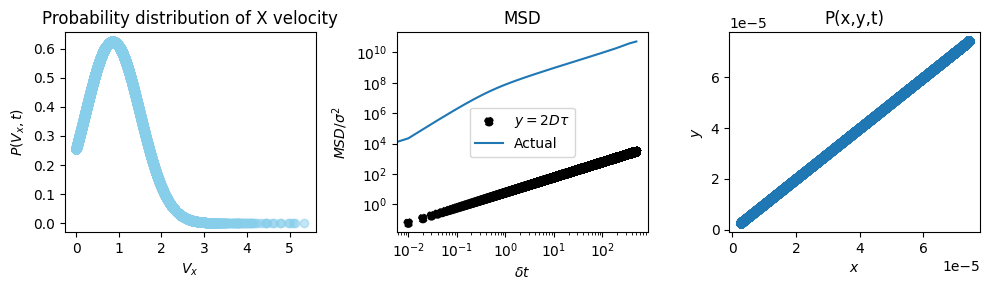

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(10,3))
#xx = np.array(x)
pdf = norm.pdf(mean_vx_per_ts,loc=mean_vx_per_ts.mean(),scale=mean_vx_per_ts.std())
axs[0].scatter(mean_vx_per_ts,pdf,c='skyblue',alpha=0.5)
axs[0].set_xlabel("$V_x$")
axs[0].set_ylabel("$P(V_x,t)$")
axs[0].set_title("Probability distribution of X velocity")
##
axs[1].scatter(lagtimes, exact,c="black", ls="--", label=r'$y=2 D\tau$')
axs[1].plot(lagtimes,msd_,label=r'Actual')
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_xlabel("$\delta t$")
axs[1].set_ylabel("$MSD/\sigma^2$")
axs[1].set_title("MSD")
axs[1].legend()
####
axs[2].scatter(pdf_xp, pdf_yp)#,c="green", ls="--", label=r'$y=2 D\tau$')

#axs[2].set_yscale('log')
#axs[2].set_xscale('log')
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$y$")
axs[2].set_title("P(x,y,t)")

fig.tight_layout()

Proposed order parameter
$$Ω = \left( g_{12}(\mathbf{x})-1\right)\sum_i^N||\mathbf{x}_1\rangle\langle\mathbf{x}_i| |$$

In [ ]:
ag1 = trj.select_atoms('all')
rdf = InterRDF(ag1, ag1,nbins=30,range=(0.5,2))
rdf.run()

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:359: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:369: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, '$g(r)-1$')

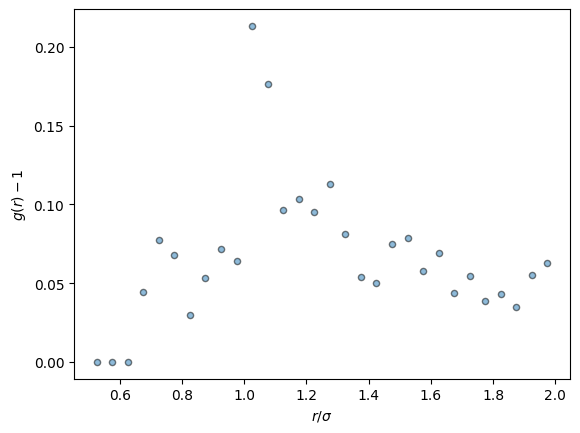

In [ ]:
fig,axs = plt.subplots()
axs.scatter(rdf.bins, rdf.rdf,s=20,alpha=0.5,edgecolors='black',label='')
#axs.set_ylim(0,None)
axs.set_xlabel("$r/\sigma$")
axs.set_ylabel("$g(r)-1$")

In [ ]:
omega = []
for ts in trj.trajectory:
  for atom in trj.atoms:
    a = atom.velocity
    particles_surrounding = trj.select_atoms(f'sphzone 1 id {atom.id}')
    # for all of the 'B' atoms within the g_r peak
    for b in particles_surrounding.velocities:
      # project velocity 'A' onto 'B'
       tmp_omega = (np.dot(a, b) / np.dot(b, b)) * b
    omega.append(tmp_omega)


/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [ ]:
o_omega = np.zeros(1,len(omega))
for ind,val in enumerate(omega):
  o_omega[ind] = val.mean()

fig,ax = plt.subplots()
ax.scatter(o_omega)
ax.set_xlabel("Particle Id")
ax.set_ylabel("$\omega$")

TypeError: Cannot interpret '5000100' as a data type